# **S**pectroscopy of **L**iquids **U**sing **R**obot gripper **P**erception 
# *(SLURP)* Data Analysis

### Author: Nathaniel Hanson
### Last Updated: 08/28/2022

In [82]:
# Main imports
import os
import csv
import typing
import os
import torch
from tqdm import tqdm
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from datetime import datetime
from sklearn import preprocessing
from typing import Dict, List, Tuple
import pandas as pd
import numpy as np
import matplotlib
from IPython.display import display
import matplotlib.pyplot as plt
from collections import defaultdict
from torch.utils.tensorboard import SummaryWriter
from utils import SpectralData, train_epochs
from models import MLP
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, cross_val_score, KFold, LeaveOneOut
# Change default figure size depending on display
matplotlib.rcParams['figure.figsize'] = [10, 5]

### Part 0: Read in all spectrometer data

In [2]:
# Read in all data
read_files = os.listdir('data')
readings = {z.split('.')[0]:pd.read_csv(os.path.join('./data',z)) for z in read_files}
# Remove extra data fields from the readings
for key in readings.keys():
    readings[key] = readings[key].loc[:,list(readings[key].columns)[:-5]].to_numpy().astype(np.int32)

### Perform reflectance calibraiton across all data samples

In [3]:
# Read in calibration data
hamamatsu_dark = np.median(pd.read_csv('./calibration/hamamatsu_black_ref.csv').to_numpy().astype(np.int32), axis=0)
hamamatsu_white = np.median(pd.read_csv('./calibration/hamamatsu_white_ref.csv').to_numpy().astype(np.int32), axis=0)
mantispectra_dark = np.median(pd.read_csv('./calibration/mantispectra_black_ref.csv').to_numpy()[:,:-5].astype(np.int32), axis=0)
mantispectra_white = np.median(pd.read_csv('./calibration/mantispectra_white_ref.csv').to_numpy()[:,:-5].astype(np.int32), axis=0)

# Create composite calibration file
white_ref = np.concatenate((hamamatsu_white, mantispectra_white))
dark_ref = np.concatenate((hamamatsu_dark, mantispectra_dark))

# Create calibration function
def spectral_calibration(reading):
    t = np.divide((reading-dark_ref), (white_ref-dark_ref), where=(white_ref-dark_ref)!=0)
    # Handle cases where there is null division, which casts values as "None"
    if np.sum(t==None) > 0:
        print('Null readings!')
    t[t== None] = 0
    # Handle edge cases with large spikes in data, clip to be within a factor of the white reference to avoid skewing the model
    t = np.clip(t,-2,2)
    return t

In [4]:
# Calibrate all the data
readings_cal = {}
for key in readings.keys():
    readings_cal[key] = np.apply_along_axis(spectral_calibration,1,readings[key])

### Read label data for each experiment

In [5]:
# Read in the container-substrate pairings
pairings = pd.read_csv('./container_substrate.csv',header=1, keep_default_na=False)
# Remove blank data rows
pairings = pairings.loc[:18,(pairings.columns)[:20]]
# Unique substances
contents = list(pairings.columns[2:])
display(pairings)

,Unnamed: 0,container / substrate,Milk,Almond Milk,Vinegar,Orange Juice,Ketchup,Soy Sauce,Water,Sugar Water,Olive oil,Vegetable Oil,Liquid Soap,Tylenol (PM),Ibuprofen,Salt,Sugar,Baking Soda,Flour,Coke
0,A,Silicone,A0,A1,A2,A3,A4,A6,A7,A9,A10,A11,A12,A13,A14,A15,A16,A17,A18,A19
1,B,,B0,B1,B2,B3,B4,B6,B7,B9,B10,B11,B12,B13,B14,B15,B16,B17,B18,B19
2,C,,C0,C1,C2,C3,C4,C6,C7,C9,C10,C11,C12,C13,C14,C15,C16,C17,C18,C19
3,E,PP,E0,E1,E2,E3,E4,E6,E7,E9,E10,E11,E12,E13,E14,E15,E16,E17,E18,E19
4,F,,F0,F1,F2,F3,F4,F6,F7,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19
5,G,,G0,G1,G2,G3,G4,G6,G7,G9,G10,G11,G12,G13,G14,G15,G16,G17,G18,G19
6,H,,H0,H1,H2,H3,H4,H6,H7,H9,H10,H11,H12,H13,H14,H15,H16,H17,H18,H19
7,I,,I0,I1,I2,I3,I4,I6,I7,I9,I10,I11,I12,I13,I14,I15,I16,I17,I18,I19
8,J,HDPE,J0,J1,J2,J3,J4,J6,J7,J9,J10,J11,J12,J13,J14,J15,J16,J17,J18,J19
9,K,Acrylic,K0,K1,K2,K3,K4,K6,K7,K9,K10,K11,K12,K13,K14,K15,K16,K17,K18,K19


In [6]:
# Generalized function to group data by the contents type
def sort_by_contents(readings: Dict) -> defaultdict:
    data_by_contents = defaultdict(lambda: np.array([]))
    # Iterate over all data_frames types
    for key in readings.keys():
        # Iterate over all containers, but skip Aluminum (P), Stainless Steel (Q), and Wood (R)
        if 'P' in key or 'Q' in key or 'R' in key:
            continue
        for index, val in enumerate(contents):
            if key not in list(pairings[val]):
                continue
            # Otherwise the data is useful to use, let's proceed with the data wrangling
            useData = readings[key]
            # Add the index as the key value
            data_by_contents[val] = np.vstack((data_by_contents[val], useData)) if data_by_contents[val].size else useData
    return data_by_contents

# Create labels from category data
def label_categories(data_by_contents: defaultdict) -> Tuple[np.ndarray, List]:
    # Create all catgeory data with labels
    all_data = []
    labels = []
    for key in data_by_contents.keys():
        n_samples = data_by_contents[key].shape[0]
        labels.append([key]*n_samples)
        all_data = np.vstack((all_data,data_by_contents[key])) if len(all_data) > 0 else data_by_contents[key]
    labels = np.array([item for sublist in labels for item in sublist])
    return all_data, labels

In [7]:
# Generate uncalibrated groupings
data_by_contents = sort_by_contents(readings)
# Generate calibrated groupings
data_by_contents_cal = sort_by_contents(readings_cal)

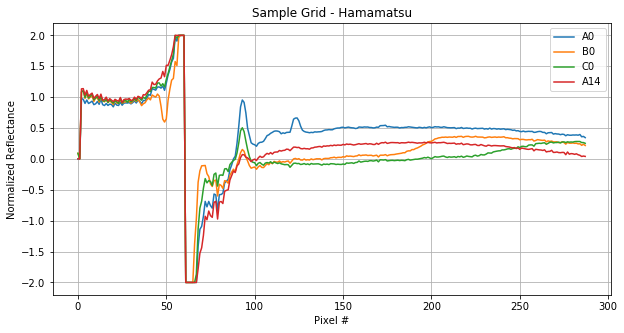

In [8]:
# Plot a sample of the Hamamatsu derived data
plt.plot(readings_cal['A0'][0,:-16], label='A0')
plt.plot(readings_cal['B0'][0,:-16], label='B0')
plt.plot(readings_cal['C0'][0,:-16], label='C0')
plt.plot(readings_cal['A14'][0,:-16], label='A14')
plt.grid()
plt.legend()
plt.title('Sample Grid - Hamamatsu')
plt.xlabel('Pixel #')
plt.ylabel('Normalized Reflectance')
plt.show()

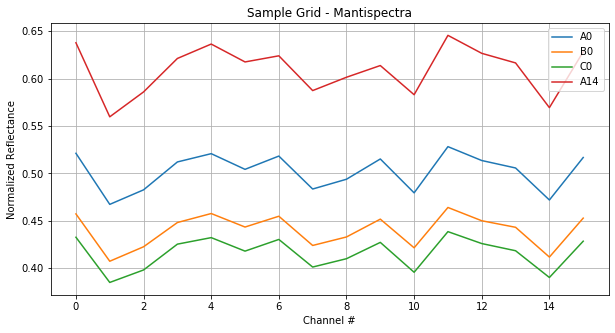

In [10]:
# Plot a sample of the Mantispectra derived data
plt.plot(readings_cal['A0'][0,-16:], label='A0')
plt.plot(readings_cal['B0'][0,-16:], label='B0')
plt.plot(readings_cal['C0'][0,-16:], label='C0')
plt.plot(readings_cal['A14'][0,-16:], label='A14')
plt.grid()
plt.legend()
plt.title('Sample Grid - Mantispectra')
plt.xlabel('Channel #')
plt.ylabel('Normalized Reflectance')
plt.show()

In [9]:
# Create all catgeory data with labels
all_data, labels = label_categories(data_by_contents)
all_data_cal, labels_cal = label_categories(data_by_contents_cal)

### Part 1: Train MLP on all available data

In [12]:
# Train model on all available data
X_train, X_test, y_train, y_test = train_test_split(
    all_data_cal, labels_cal, test_size=0.30)

In [12]:
# Start by fitting a classifier on all the data
for k in range(2,11):
    cv = KFold(n_splits=k, shuffle=True)
    clf = MLPClassifier(max_iter=1000, hidden_layer_sizes=(300,100,50,25,10),verbose=False)
    scores = cross_val_score(clf, all_data_cal, labels, scoring='accuracy', cv=cv, n_jobs=-1)
    #.fit(X_train, y_train)
    print(f'Accuracy with k={k}: Mean:{np.mean(scores)} Std:{np.std(scores)}')

Accuracy with k=2: Mean:0.5809027777777778 Std:0.010763888888888906
Accuracy with k=3: Mean:0.6798611111111111 Std:0.0321100778380469
Accuracy with k=4: Mean:0.6645833333333333 Std:0.016002386974726265
Accuracy with k=5: Mean:0.6315972222222223 Std:0.09581949376719993
Accuracy with k=6: Mean:0.6649305555555555 Std:0.018919628785868444
Accuracy with k=7: Mean:0.694809182974444 Std:0.04928178527284864
Accuracy with k=8: Mean:0.6756944444444444 Std:0.046017097936192526
Accuracy with k=9: Mean:0.6784722222222221 Std:0.03212133992216173
Accuracy with k=10: Mean:0.690625 Std:0.03317562518599283


In [14]:
# Also look into leave one out cross validaiton
cv = LeaveOneOut()
# enumerate splits
y_true, y_pred = list(), list()
for train_ix, test_ix in cv.split(all_data_cal):
	# split data
	X_train, X_test = all_data_cal[train_ix, :], all_data_cal[test_ix, :]
	y_train, y_test = labels_cal[train_ix], labels_cal[test_ix]
	# fit model
	model = MLPClassifier(max_iter=1000, hidden_layer_sizes=(300,100,50,25,10),verbose=False)
	model.fit(X_train, y_train)
	# evaluate model
	yhat = model.predict(X_test)
	# store
	y_true.append(y_test[0])
	y_pred.append(yhat[0])
# calculate accuracy
acc = accuracy_score(y_true, y_pred)
print('Accuracy: %.3f' % acc)

TypeError: only integer scalar arrays can be converted to a scalar index

In [83]:
y_pred = clf.predict(X_test)
clf.score(X_test, y_test)

0.5810185185185185

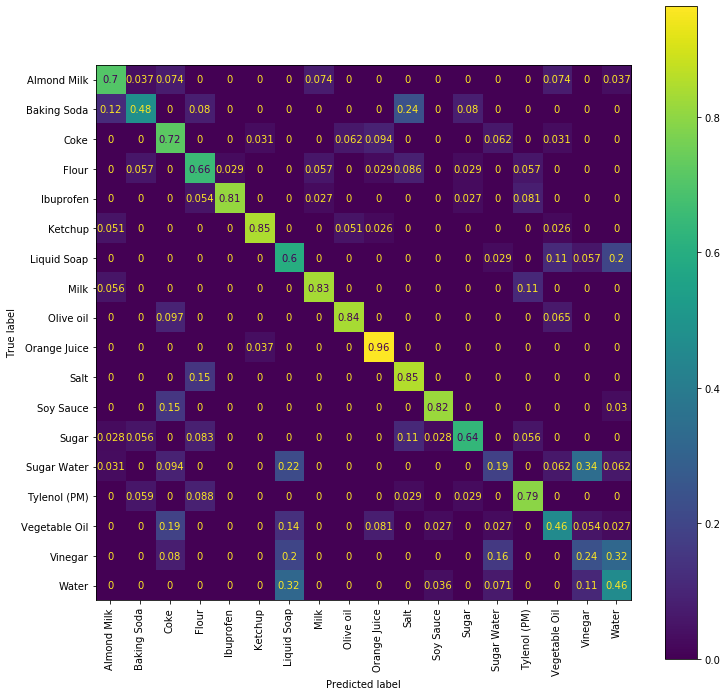

In [79]:
from sklearn.metrics import ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred,normalize='true')
plt.xticks(rotation = 90) # Rotates X-Axis Ticks by 45-degrees
fig = disp.ax_.get_figure() 
fig.set_figwidth(12)
fig.set_figheight(12)  
plt.show()

In [ ]:
### Part 1b: Train on only the Mantispectra Data
model = MLPClassifier(max_iter=1000, hidden_layer_sizes=(200,100,50,25,10),verbose=True)
model.fit(X_train[:,:-16], y_train)

Iteration 1, loss = 2.91434421
Iteration 2, loss = 2.88410971
Iteration 3, loss = 2.87274030
Iteration 4, loss = 2.85672710
Iteration 5, loss = 2.84803831
Iteration 6, loss = 2.83230566
Iteration 7, loss = 2.81235769
Iteration 8, loss = 2.80284752
Iteration 9, loss = 2.78554774
Iteration 10, loss = 2.76573059
Iteration 11, loss = 2.74794640
Iteration 12, loss = 2.71841143
Iteration 13, loss = 2.71041609
Iteration 14, loss = 2.68644261
Iteration 15, loss = 2.66483355
Iteration 16, loss = 2.66042120
Iteration 17, loss = 2.64878018
Iteration 18, loss = 2.62126240
Iteration 19, loss = 2.57974703
Iteration 20, loss = 2.59797976
Iteration 21, loss = 2.56949395
Iteration 22, loss = 2.54234199
Iteration 23, loss = 2.52406880
Iteration 24, loss = 2.48960120
Iteration 25, loss = 2.47057755
Iteration 26, loss = 2.45495900
Iteration 27, loss = 2.45665386
Iteration 28, loss = 2.43789381
Iteration 29, loss = 2.41441110
Iteration 30, loss = 2.42564908
Iteration 31, loss = 2.39103160
Iteration 32, los

In [ ]:
### Part 1c: Train on only the Hamamatsu Data

In [13]:
D = all_data_cal.shape[1]
K = len(data_by_contents_cal.keys())

# find device to train on

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')

# use model that did well in cross val

num_perceptrons = [256, 128]
num_hidden_layers = len(num_perceptrons)
use_dropout = True
model = MLP(D, K, num_hidden_layers, num_perceptrons, 
            use_dropout).to(device).double()

Using cuda device


In [34]:
model

MLP(
  (relu): ReLU()
  (dropout): Dropout(p=0.25, inplace=False)
  (fc_input): Linear(in_features=304, out_features=256, bias=True)
  (fc_list): ModuleList(
    (0): Linear(in_features=256, out_features=128, bias=True)
  )
  (fc_output): Linear(in_features=128, out_features=18, bias=True)
)

In [42]:
# start training
n_epochs = 100
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [43]:
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/spectral_train_{}'.format(timestamp))
save_prefix = "spectral"

train_args = {
    "model": model,
    "loss_fn": loss_fn,
    "optimizer": optimizer,
    "device": device,
    "n_epochs": n_epochs,
    "writer": writer,
    "save_prefix": save_prefix
}

In [44]:
le = preprocessing.LabelEncoder()
targets = le.fit_transform(labels_cal)

In [50]:
all_data_cal.dtype

dtype('float64')

In [51]:
X_train, X_test, y_train, y_test = train_test_split(all_data_cal.astype(np.double), targets, test_size=0.2, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

In [68]:
train_dataset = TensorDataset(torch.Tensor(X_train),torch.Tensor(y_train).type(torch.LongTensor)) # Main train set
valid_dataset = TensorDataset(torch.Tensor(X_val),torch.Tensor(y_val).type(torch.LongTensor))  # Validation set
test_dataset = TensorDataset(torch.Tensor(X_test),torch.Tensor(y_test).type(torch.LongTensor))  # Test set

In [69]:
torch.Tensor(X_train)

tensor([[-0.0000, -0.0000,  1.0394,  ...,  0.4171,  0.4091,  0.4511],
        [-0.0000, -0.0000,  0.9134,  ...,  0.2128,  0.2081,  0.2150],
        [-0.0000, -0.0000,  1.3071,  ...,  0.2019,  0.2022,  0.2031],
        ...,
        [-0.0000, -0.0000,  0.8661,  ...,  1.3342,  1.3498,  1.3633],
        [-0.0000, -0.0000,  1.3386,  ...,  0.0575,  0.0609,  0.0609],
        [-0.0000, -0.1000,  1.3543,  ...,  0.0557,  0.0560,  0.0550]])

In [76]:
train_loader = DataLoader(dataset=train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(dataset=valid_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=128, shuffle=False)

In [86]:
train_loss = []
val_loss = []
epochs = 1000

for epoch in tqdm(range(epochs)):
    model.train()
    running_loss = 0
    last_loss = 0
    total_correct = 0
    running_loss_train = 0
    for i, data in enumerate(train_loader):
        inputs, true_labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        
        outputs = model(inputs.double())
        loss = loss_fn(outputs, true_labels)
        loss.backward()
        optimizer.step()
        
        running_loss_train += loss.item()

        # calculate accuracy
        pred_labels = torch.argmax(outputs, dim=1, keepdim=False)
        # true_labels = torch.argmax(true_labels, dim=1, keepdim=False)
        correct = (pred_labels == true_labels).float().sum()
        total_correct += correct

        if i % 100 == 99:
            last_loss = running_loss_train / 100

    # Keep track of train loss
    train_loss.append(last_loss)
    
    model.train(False)
    running_loss_val = 0.0
    correct = 0
    for i, val_data in enumerate(val_loader):
        inputs, true_labels = val_data[0].to(device), val_data[1].to(device)
        
        # calculate loss
        output = model(inputs.double())
        loss = loss_fn(output, true_labels)
        running_loss_val += loss.item()

        # calculate accuracy
        pred_labels = torch.argmax(output, dim=1, keepdim=False)
        # true_labels = torch.argmax(true_labels, dim=1, keepdim=False)
        correct += (pred_labels == true_labels).float().sum()

    avg_val_loss = running_loss_val / (i + 1)
    val_loss.append(avg_val_loss)

100%|███████████████████████████████████████| 1000/1000 [00:20<00:00, 48.95it/s]


Text(0.5, 1.0, 'results/spectral/spectral train vs. validation loss')

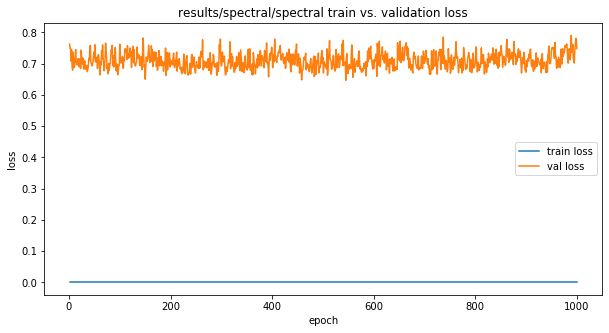

In [87]:
# view training results

plt.figure(1)
plt.plot(range(1, len(train_loss) + 1), train_loss, label="train loss")
plt.plot(range(1, len(train_loss) + 1), val_loss, label="val loss")
plt.legend()
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("results/spectral/spectral train vs. validation loss")
#plt.savefig("results/spectral/spectral_train_val_loss.png")

# plt.figure(2)
# plt.plot(range(1, len(val_acc) + 1), np.array(val_acc) * 100, label="val accuracy")
# plt.legend()
# plt.xlabel("epoch")
# plt.ylabel("accuracy")
# plt.title("spectral validation accuracy")
# plt.savefig("results/spectral/spectral_val_acc.png")

# plt.show()
